In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import pickle
warnings.filterwarnings('ignore')
% matplotlib inline

In [2]:
from model_generator import *

### Generate df

In [3]:
paths_dict_band = json.load(open('inputs_json/paths_dict_band.json', 'r'))

In [4]:
band = generate_df(paths_dict_band, 'band', '2016')

In [5]:
df = band.return_completed_df()

In [6]:
name_list_24 = ['band']

In [7]:
feature_eng_df = band.return_df_feature_engineering(name_list_24)

In [8]:
band_mean_vol_aemet = pd.read_csv('aemet/band_mean_vol_pred_aemet.csv', encoding='latin1', index_col=0)

In [9]:
final_df = feature_eng_df.merge(band_mean_vol_aemet, how='left', left_index=True, right_index=True)

In [10]:
for feature in ['pred_band_mean_aemet', 'pred_band_vol_aemet']:
    final_df[feature].fillna(method='pad', inplace=True)

### Train model

In [11]:
lgbm_model = train_model(df=final_df, output='band',
                        features_to_remove=['hour', 'weekday', 'season'],
                        n_folds=5, cv_type='normal')

In [12]:
lgbm_model_grouped = train_model(df=final_df, output='band', features_to_remove=['hour', 'weekday', 'season'],
                                n_folds=5, cv_type='group')

In [15]:
from lightgbm import LGBMRegressor
pipeline = LGBMRegressor(num_leaves=60, learning_rate=0.08, n_estimators=1000, seed=0)
pipeline_group = LGBMRegressor(num_leaves=40, learning_rate=0.05, n_estimators=700, seed=0)

In [16]:
lgbm_model.obtain_cv_score(pipeline)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 3.0317 +- 0.0374
Mean squared error: 24.2311 +- 4.3389


In [17]:
lgbm_model_grouped.obtain_cv_score(pipeline_group)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 4.1709 +- 0.2707
Mean squared error: 39.3443 +- 13.1173


In [18]:
lgbm_model.obtain_train_test_error(pipeline)

Train MAE: 0.648802603168, Train MSE: 1.25994597552
Test MAE: 2.84596869604, Test MSE: 18.8891285633


In [19]:
lgbm_model_grouped.obtain_train_test_error(pipeline_group)

Train MAE: 1.67806748806, Train MSE: 5.14010279431
Test MAE: 4.60931483142, Test MSE: 60.1393936096


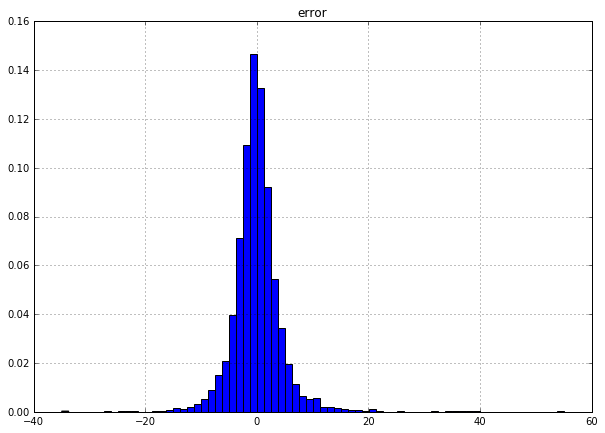

In [20]:
lgbm_model.plot_histogram_error()

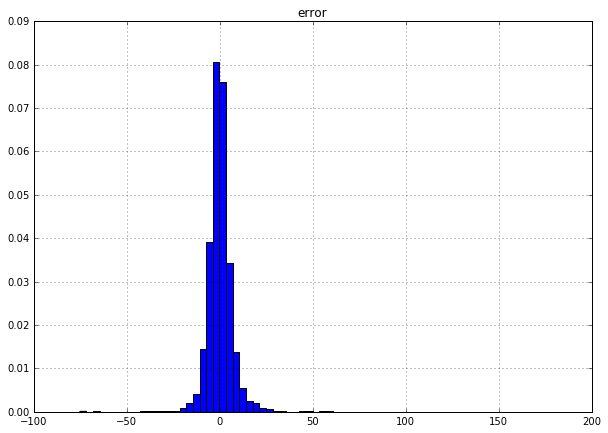

In [21]:
lgbm_model_grouped.plot_histogram_error()

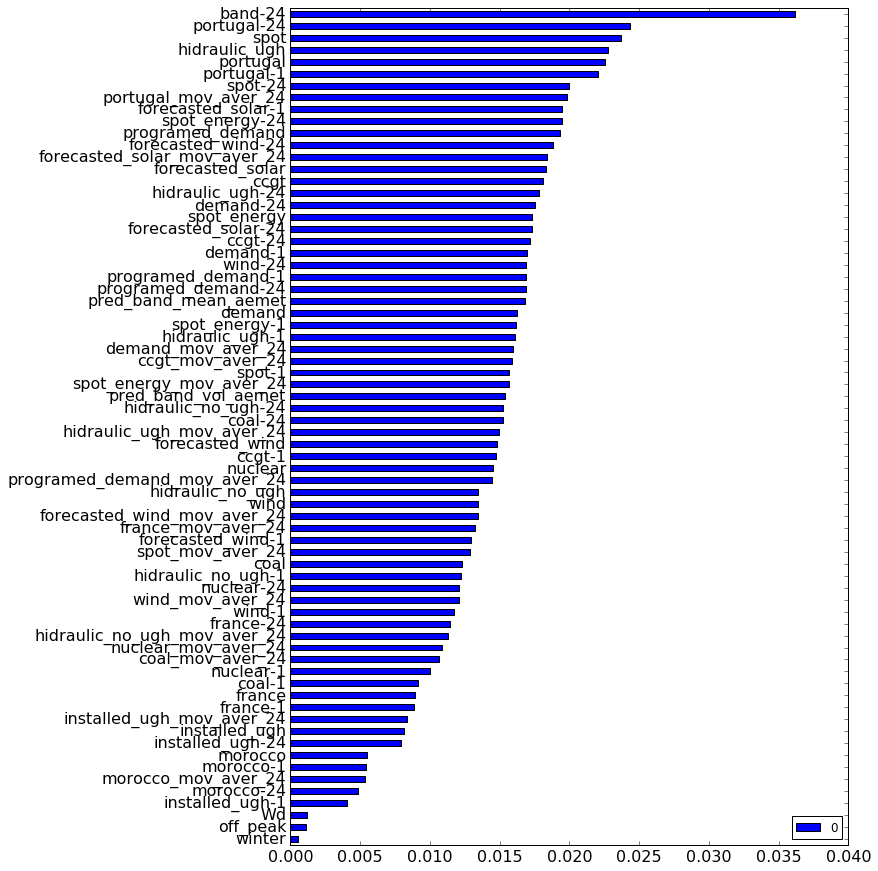

In [22]:
lgbm_model.plot_feature_importance()

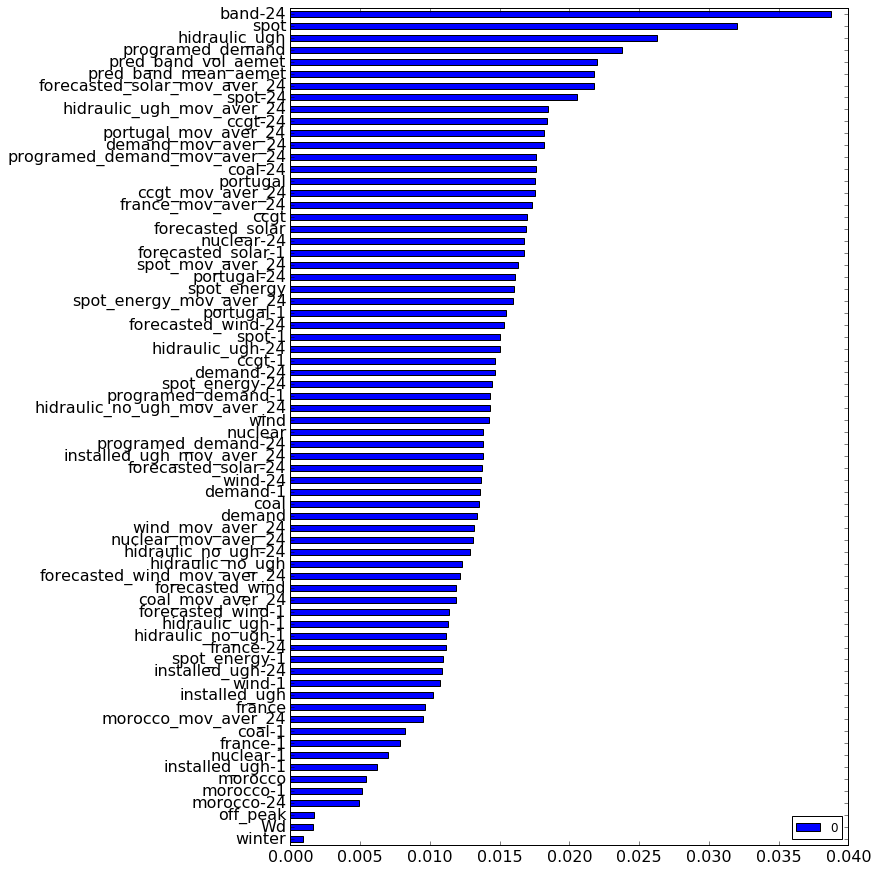

In [23]:
lgbm_model_grouped.plot_feature_importance()

In [24]:
residuals_model = lgbm_model.get_log_residuals()

In [25]:
residuals_model_group = lgbm_model_grouped.get_log_residuals()

### Export residuals and model

In [26]:
with open('models_p/lgbm_band.p', 'wb') as f:
    pickle.dump(lgbm_model.pipeline, f)
    
with open('inputs_json/feature_list_band_lgbm.json', 'w') as f:
    json.dump(lgbm_model.features_list, f)
    
residuals_model.to_json('inputs_json/residuals_band_lgbm.json',
                       orient='index', date_format='iso')